In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from corner import corner
import copy

import torch
import torch.nn as nn
import torch.optim as optim 
import normflows as nf
device='cuda'

In [2]:
from tools.noise_scheduler import noise_scheduler
from tools.loss import unified_loss
from tools.score_net import score_model_mlp_cond
from tools.sampling import ddpm_sampler,ddim_sampler,annealed_langevin_dynamic_sampler
from tools.utils import plot_gradient

In [19]:
import sbibm
from sbibm.metrics import mmd

task = sbibm.get_task("two_moons")  # See sbibm.get_available_tasks() for all tasks
prior = task.get_prior()
simulator = task.get_simulator()

# These objects can then be used for custom inference algorithms, e.g.
# we might want to generate simulations by sampling from prior:
thetas = prior(num_samples=10000)
samples = simulator(thetas)

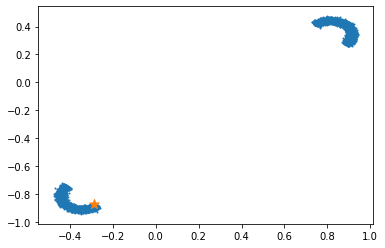

In [20]:
import os
obs_loc='datasets/sbibm_tasks/two_moons/files/num_observation_2/'
obs=np.loadtxt(os.path.join(obs_loc,'observation.csv'),delimiter=',',skiprows=1)
true_theta=np.loadtxt(os.path.join(obs_loc,'true_parameters.csv'),delimiter=',',skiprows=1)
ref_posterior=np.loadtxt(os.path.join(obs_loc,'reference_posterior_samples.csv'),delimiter=',',skiprows=1)

plt.scatter(ref_posterior[:,0],ref_posterior[:,1],s=1)
plt.scatter(true_theta[0],true_theta[1],marker='*',s=100)

In [21]:
# ns=noise_scheduler(1e-4,1e-3,100,schedule='linear',var_norm=True)
ns=noise_scheduler(1e-4,1e-3,100,schedule='sigmoid',var_norm=True)

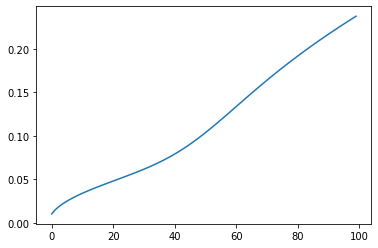

In [22]:
ns.plot_marginal_std()

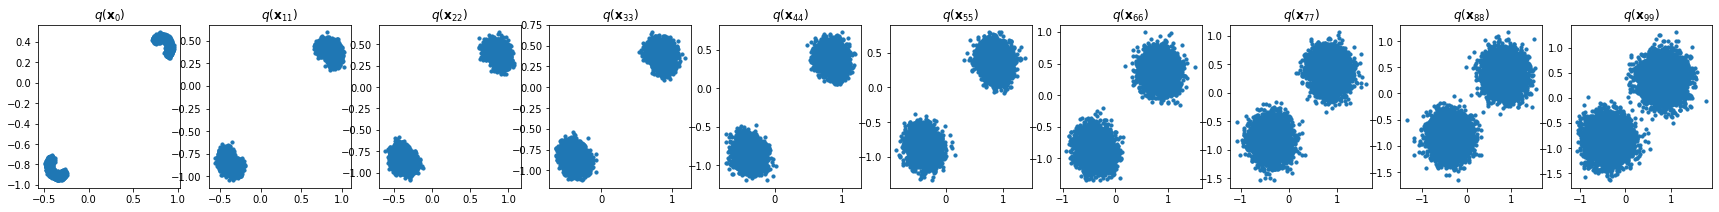

In [23]:
ns.visualize_noise(torch.tensor(ref_posterior))

In [24]:
model = score_model_mlp_cond(input_dim=2,cond_dim=2,n_steps=100,hidden=[256,512,512]).to(device)
# model = score_model_mlp(x_dim=2,n_steps=100,hidden_dim=[256,512,512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [25]:
dataset=torch.tensor(samples).float().to(device)
thetas=torch.tensor(thetas).float().to(device)
epochs = 1000
batch_size = 128
for epoch in range(epochs):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = thetas[indices]
        batch_x_cond = dataset[indices]

        t = torch.randint(0, ns.n_steps, size=(batch_x.shape[0] // 2 + 1,))
        t = torch.cat([t, ns.n_steps - t - 1], dim=0)[:batch_x.shape[0]].long().to(device)
        # Compute the loss.
        loss = unified_loss(model, batch_x,t,ns,batch_x_cond)

        optimizer.zero_grad()
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

    if (epoch % 100 == 0):
        print(loss.item())


/tmp/ipykernel_31593/2052494755.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset=torch.tensor(samples).float().to(device)
/tmp/ipykernel_31593/2052494755.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas=torch.tensor(thetas).float().to(device)


1.0158629417419434
0.3566908836364746
0.5463907718658447
0.2412397861480713
0.2106938362121582
0.17989309132099152
0.3612034320831299
0.3882894814014435
0.3126770853996277
0.361299604177475


In [30]:
sampler=ddpm_sampler(model,ns,device=device)

In [27]:
# sample_cond=torch.tensor(np.repeat(obs[None,:],thetas.shape[0],axis=0)).float().to(device)
# x_seq=sampler.loop_sample(thetas.shape,sample_cond=sample_cond)

sample_cond=torch.tensor(np.repeat(obs[None,:],10000,axis=0)).float().to(device)
x_seq=sampler.loop_sample((10000,2),sample_cond=sample_cond)

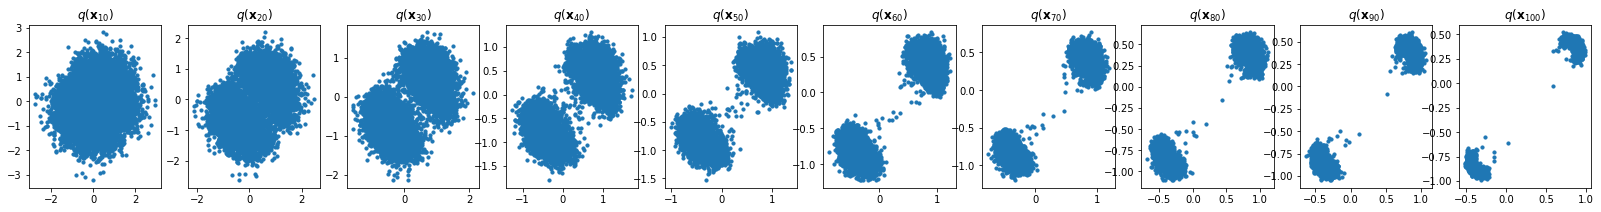

In [28]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(1, 11):
    cur_x = x_seq[i*10].detach().cpu()
    axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
    #axs[i-1].set_axis_off(); 
    axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

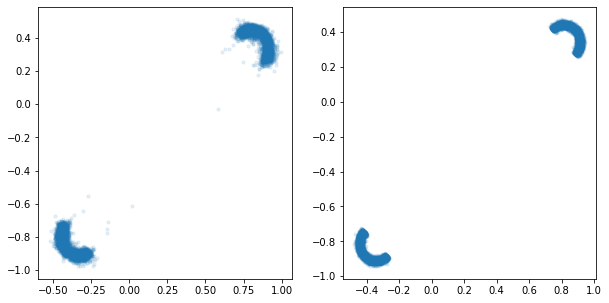

In [29]:
final=(x_seq[-1].detach().cpu())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(*final.T , s=10, alpha=0.1)

plt.subplot(1, 2, 2)
plt.scatter(*ref_posterior.T, s=10, alpha=0.1)


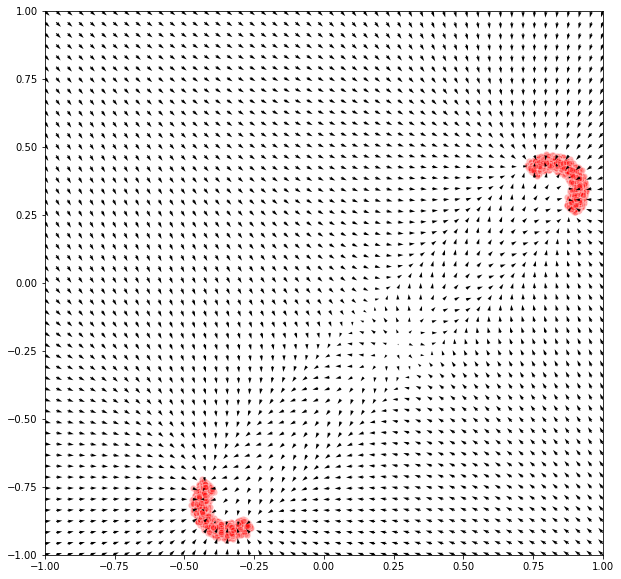

In [30]:
plot_gradient(model,(-1,1),(-1,1),n=50,t=0,score_cond=obs,ref_data=ref_posterior)

In [33]:
from tools.sampling import ddim_sampler

In [34]:
sampler_20x=ddim_sampler(model, ns, eta=0,tau=20, device='cuda', scheduling = 'uniform',)
sampler_1x=ddim_sampler(model, ns, eta=1,tau=1, device='cuda', scheduling = 'uniform')

In [35]:
%%timeit
x_seq_ddpm=sampler_1x.loop_sample(thetas.shape,sample_cond=sample_cond)

121 ms ± 400 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
%%timeit
x_seq_ddim=sampler_20x.loop_sample(thetas.shape,sample_cond=sample_cond)

6.23 ms ± 19.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
x_seq_ddpm=sampler_1x.loop_sample(thetas.shape,sample_cond=sample_cond)
x_seq_ddim=sampler_20x.loop_sample(thetas.shape,sample_cond=sample_cond)

Text(0.5, 1.0, 'Real Data')

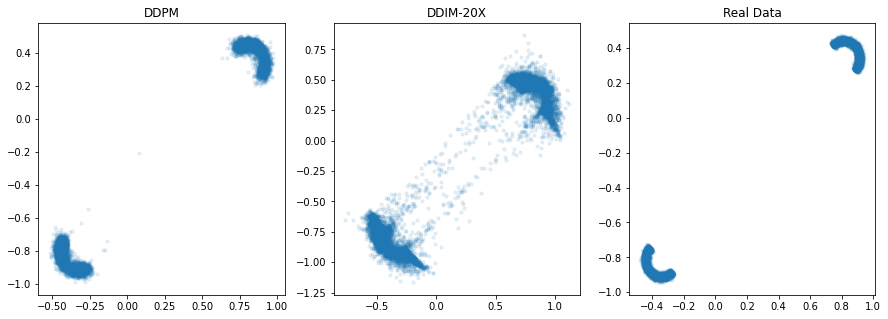

In [38]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(*x_seq_ddpm[-1].detach().cpu().T, s=10, alpha=0.1)
plt.title('DDPM')

plt.subplot(1, 3, 2)
plt.scatter(*x_seq_ddim[-1].detach().cpu().T, s=10, alpha=0.1)
plt.title('DDIM-20X')

plt.subplot(1, 3, 3)
plt.scatter(*ref_posterior.T, s=10, alpha=0.1)
plt.title('Real Data')


## BGLM

In [3]:
import sbibm
from sbibm.metrics import mmd

task = sbibm.get_task("bernoulli_glm")  # See sbibm.get_available_tasks() for all tasks
prior = task.get_prior()

simulator = task.get_simulator()

# These objects can then be used for custom inference algorithms, e.g.
# we might want to generate simulations by sampling from prior:
thetas = prior(num_samples=10000)
samples = simulator(thetas)



In [4]:


#normalize thetas to [-1,1]
thetas_min=thetas.min(0).values
thetas_max=thetas.max(0).values
thetas=(thetas-thetas_min)/(thetas_max-thetas_min)*2-1

def inverse_norm(thetas):
    return (thetas+1)*(thetas_max-thetas_min)/2+thetas_min

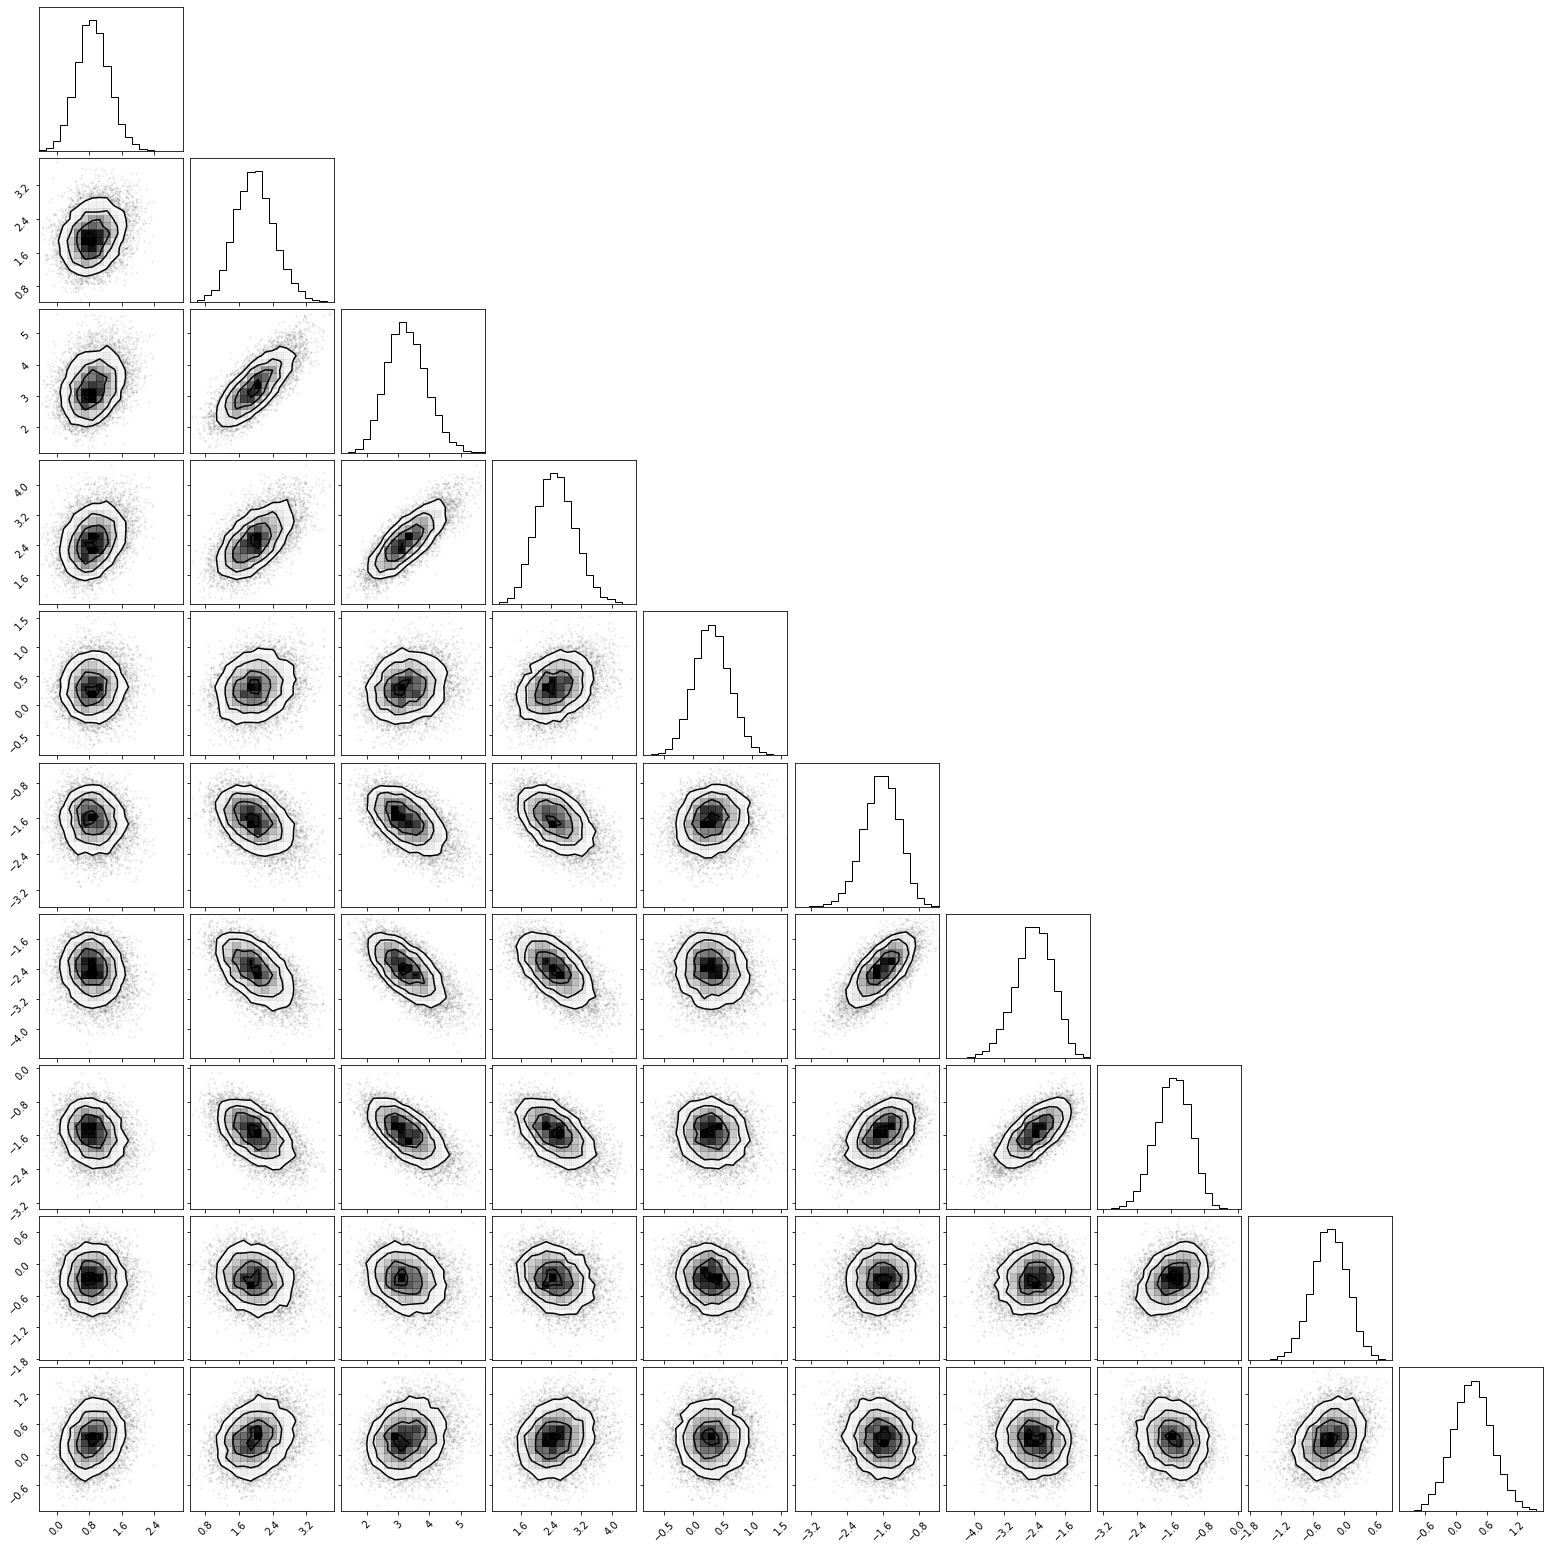

In [5]:
import os

obs_loc='datasets/sbibm_tasks/bernoulli_glm/files/num_observation_1'

obs=np.loadtxt(os.path.join(obs_loc,'observation.csv'),delimiter=',',skiprows=1)

true_theta=np.loadtxt(os.path.join(obs_loc,'true_parameters.csv'),delimiter=',',skiprows=1)

ref_posterior=np.loadtxt(os.path.join(obs_loc,'reference_posterior_samples.csv'),delimiter=',',skiprows=1)

# ref_posterior=torch.tensor(ref_posterior).float()
# #norm ref_posterior
# ref_posterior=(ref_posterior-thetas_min)/(thetas_max-thetas_min)*2-1
# #inverse_norm
# ref_posterior=inverse_norm(ref_posterior).numpy()

corner(ref_posterior);

In [290]:
ns=noise_scheduler(1e-5,2e-2,1000,schedule='linear',var_norm=True)
# ns=noise_scheduler(1e-5,1e-4,1000,schedule='sigmoid',var_norm=False)

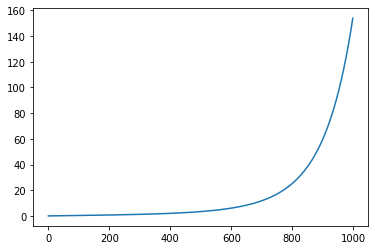

In [291]:
ns.plot_marginal_std()

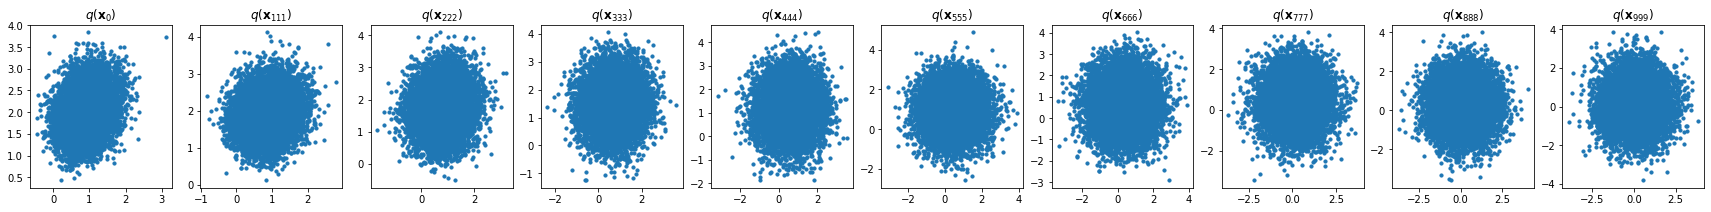

In [283]:
ns.visualize_noise(torch.tensor(ref_posterior))

In [300]:
class score_model_mlp_cond(nn.Module):
    def __init__(self, input_dim, cond_dim, n_steps,ns, hidden=[128,128]):
        '''
        current model
        activation function: GELU
        dropout: 0.2
        embedding: directly add to input
        '''
        super().__init__()
        self.input = nn.Sequential(
            nn.Linear(input_dim+cond_dim, hidden[0]),
            nn.Dropout(0.2),
            nn.GELU()
        )
        # Condition time t
        self.embedding_layer = nn.Embedding(n_steps, hidden[0])
        
        self.hidden_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(hidden[i], hidden[i+1]),
            nn.Dropout(0.2),
            nn.GELU()
        ) for i in range(len(hidden)-1)])

        self.output = nn.Linear(hidden[-1], input_dim)

        self.marg_std=(ns.marg_std).to(device)

    def forward(self, x, x_cond, t):
        x = torch.cat([x,x_cond],dim=1)
        x = self.input(x) + self.embedding_layer(t)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output(x)/self.marg_std[t][:,None]
        return x

In [301]:
model = score_model_mlp_cond(input_dim=10,cond_dim=10,n_steps=1000,hidden=[256,512,512],ns=ns).to(device)
# model = score_model_mlp(x_dim=2,n_steps=100,hidden_dim=[256,512,512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [302]:
epochs=1000
# batch = (torch.tensor(samples, dtype=torch.float32).to(device),torch.tensor(thetas, dtype=torch.float32).to(device)
dataset=torch.tensor(samples).float().to(device)
thetas=torch.tensor(thetas).float().to(device)

#split into train and val
split_permutation = torch.randperm(dataset.size()[0])
split=0.8
train_indices = split_permutation[:int(split*dataset.size()[0])]
val_indices = split_permutation[int(split*dataset.size()[0]):]

dataset_train=dataset[train_indices]
thetas_train=thetas[train_indices]

dataset_val=dataset[val_indices]
thetas_val=thetas[val_indices]

batch_size=1000
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(dataset_train.size()[0])
    train_loss=0
    for i in range(0, dataset_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = thetas_train[indices]
        batch_x_cond = dataset_train[indices]

        labels = torch.randint(0, ns.n_steps, (batch_x.shape[0],)).to(device)

        loss = unified_loss(model, batch_x, labels, ns,samples_cond=batch_x_cond)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_loss+=loss.item()*batch_x.shape[0]/dataset_train.size()[0]

    permutation = torch.randperm(dataset_val.size()[0])
    model.eval()
    val_loss=0
    best_val_loss=np.Inf
    for i in range(0, dataset_val.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = thetas_val[indices]
        batch_x_cond = dataset_val[indices]
        labels = torch.randint(0, ns.n_steps, (batch_x.shape[0],)).to(device)
        with torch.no_grad():
            loss = unified_loss(model, batch_x, labels, ns,samples_cond=batch_x_cond)
        val_loss+=loss.item()*batch_x.shape[0]/dataset_val.size()[0]
    
    if val_loss<best_val_loss:
        best_val_loss=val_loss
        best_model=copy.deepcopy(model)

    if ((epoch % 100) == 0):
        print(train_loss,val_loss)

model=best_model

/tmp/ipykernel_927356/700115001.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset=torch.tensor(samples).float().to(device)
/tmp/ipykernel_927356/700115001.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas=torch.tensor(thetas).float().to(device)


1.5439314991235733 1.0501010417938232
0.13903245143592358 0.08278191089630127
0.10896750818938017 0.05732283741235733
0.09551724512130022 0.046634577214717865
0.09225033596158028 0.04626048728823662
0.08592082839459181 0.052569152787327766
0.08587491139769554 0.043477004393935204
0.08328212611377239 0.04986925423145294
0.08413231931626797 0.04655979201197624
0.07924771215766668 0.04219592548906803


In [303]:
# sampler=annealed_langevin_dynamic_sampler(model,ns,n_iter_each_T=100,device=device,eps=1e-5)
sampler=ddpm_sampler(model,ns,device=device)


In [304]:
sample_cond=torch.tensor(np.repeat(obs[None,:],thetas.shape[0],axis=0)).float().to(device)
x_seq=sampler.loop_sample(thetas.shape,sample_cond=sample_cond)

# sample_cond=torch.tensor(np.repeat(obs[None,:],10000,axis=0)).float().to(device)
# x_seq=sampler.loop_sample((10000,2),sample_cond=sample_cond)

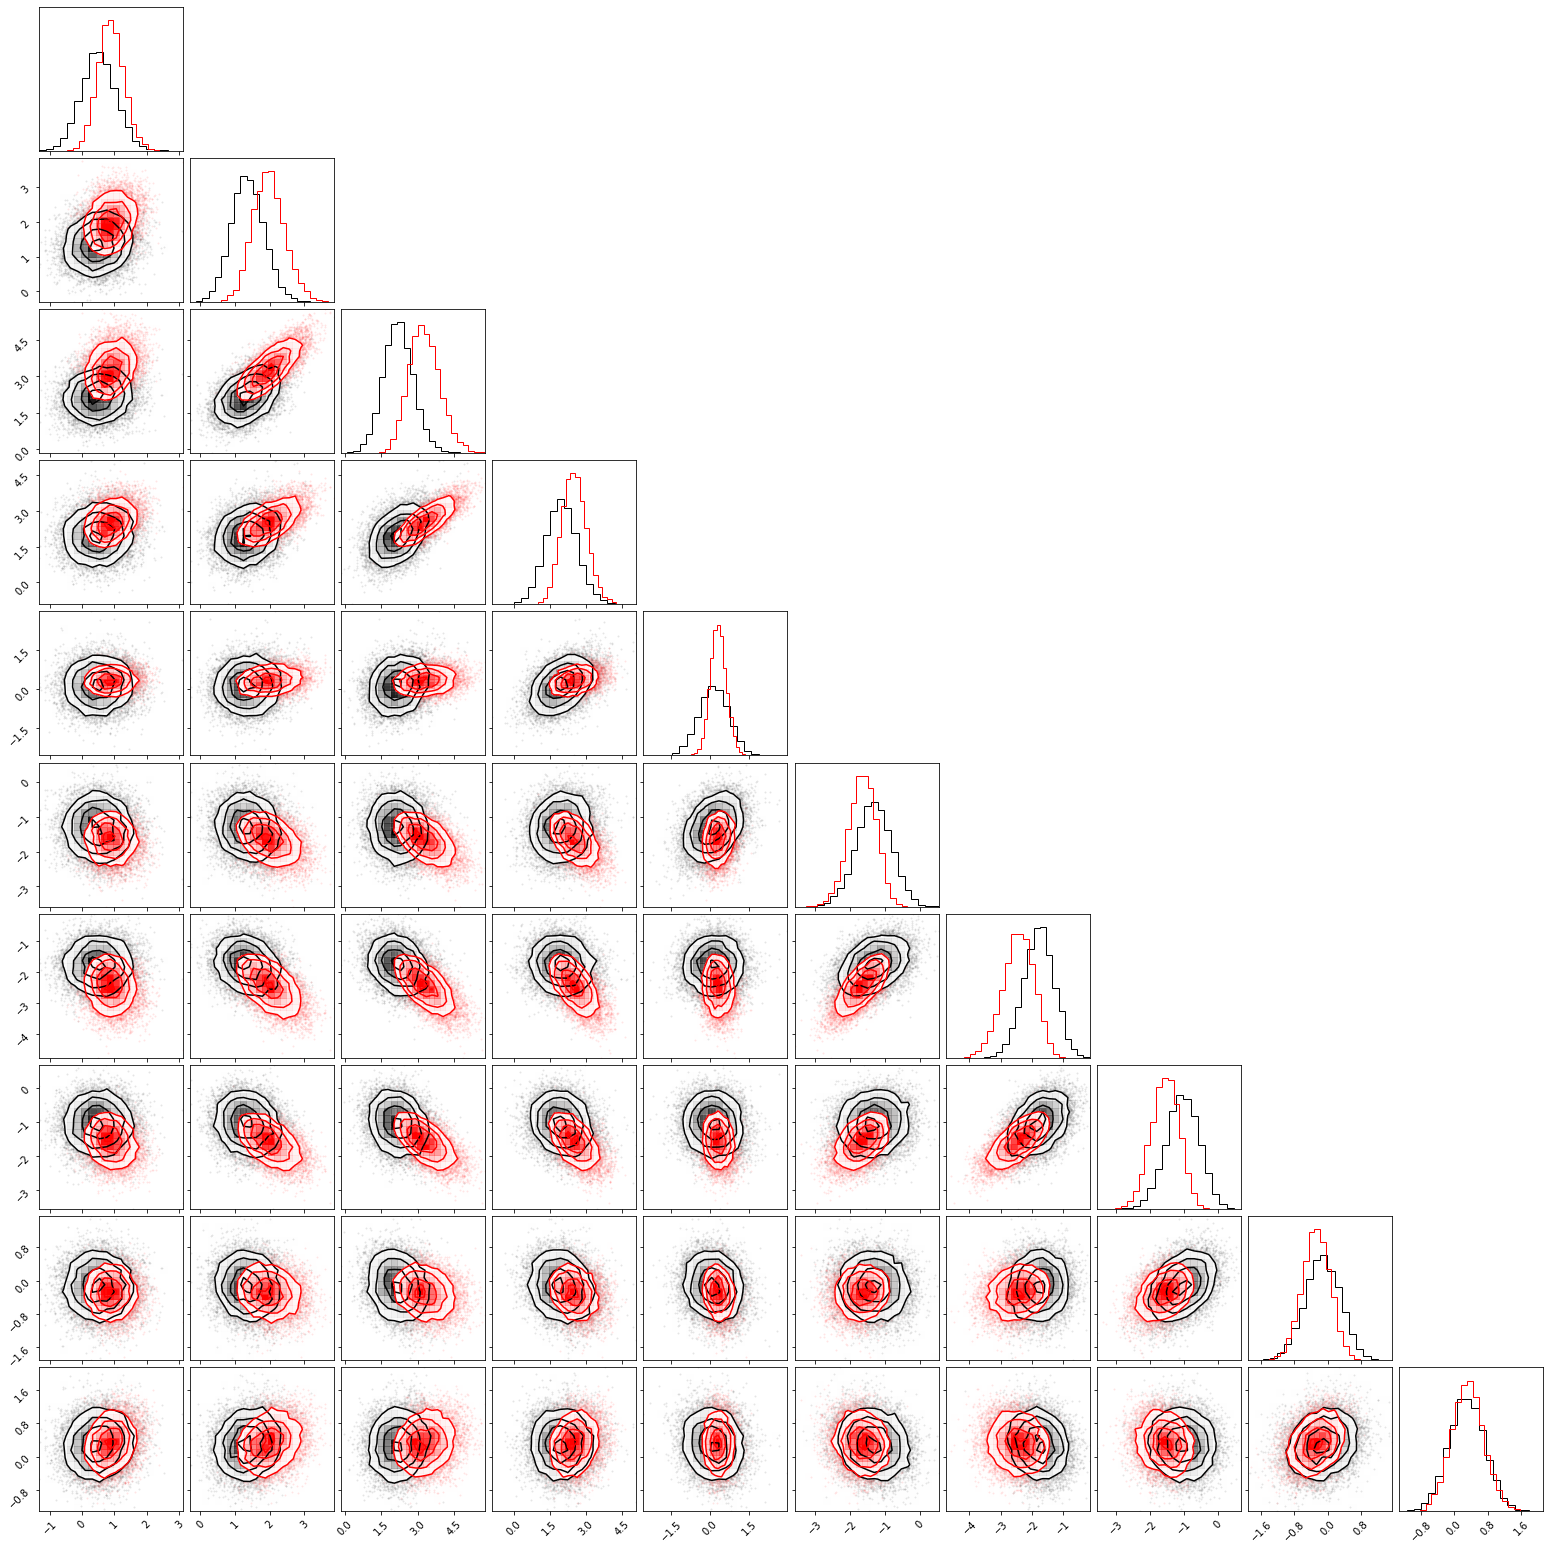

In [305]:
final=(x_seq[-1].detach().cpu())
final=inverse_norm(final).numpy()
fig=corner(final,hist_kwargs={'density':True});
corner(ref_posterior,fig=fig,color='red',hist_kwargs={'density':True});
